This notebook details a possible approach to hexagonal grid tiling with masked regions. Since floats placed in masked regions will not get advected, it is computationally inefficient to include them in the hexgrid. One possible solution is to build a uniform hex grid and then remove the floats in the masked regions. To do this, we need a function that tests to see if a float is within a masked region. 

The function `remove_test` is a possilbe way of doing this. It relies on building a [k-dtree](https://en.wikipedia.org/wiki/K-d_tree) out of the masked points for fast nearest neighbor searching. For each trial float point, we query the `k-dtree` for the 4 nearest neighbors. If all four are land points, the float is trapped in the masked region (assuming the advection scheme uses bilinear interpolation) and we should remove the float from the hexgrid. 

In [107]:
import numpy as np
from sklearn.neighbors import KDTree
from itertools import product
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

For the nearest neighbor searching, we need functions that convert from geodetic coordinates to xyz. Without loss of generality, we can map the geodetic coordinates to a unit sphere for nearest neighbor searching. 

In [108]:
def geo_to_xyz(geo_cord):
    lon_deg, lat_deg = geo_cord.transpose()
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)
    x = np.cos(lat)*np.cos(lon)
    y = np.cos(lat)*np.sin(lon)
    z = np.sin(lat)
    xyz_cord = np.transpose(np.array((x,y,z)))
    return xyz_cord

def xyz_to_geo(xyz_coord):
    x,y,z = xyz_coord.transpose()
    lat = np.arcsin(z)
    lon = np.arctan2(y,x)
    lon_deg = np.degrees(lon)
    lat_deg = np.degrees(lat)
    geo_cord = np.transpose(np.array((lon_deg, lat_deg)))
    return geo_cord

For testing purposes, we build a "mask" on a regular grid and randomly assign a boolean to each grid point with `True` indicating ocean and `False` indicating land. 

In [109]:
mask_lat = np.linspace(-90,90,20) # 1D array of 40 evenly spaced latitudes  
mask_lon = np.linspace(-180,180,20) # 1D array of 40 evenly spaced longitudes 
mask_geo = np.dstack(np.meshgrid(mask_lon, mask_lat)).reshape(-1, 2) # equiv. to cartesian product of lat and lon
mask_bool = np.random.randint(0,2, len(mask_geo)).astype('bool') # 1D array of rand bools
mask_xyz = geo_to_xyz(mask_geo) # 1D array of xyz coordinate pairs [x, y, z]

In the nearest neighbor search, the `KDTree` searches for the minimum Euclidian distance between two locations. Given our spherical geometry, this corresponds to the chord distance between two locations (which is not the great circle distance!). 

Say we wish to order a set of locations by their chord distance from a fixed location. Such an ordring by chord distance is identical to an ordering by great circle distance. To see this, let two locations on the sphere be seperated by an absolute angle of $ \Delta \alpha $. The great circle distance is given by $s = R \Delta \alpha $ and the chord distance is given by $c = 2R \sin(\Delta \alpha/2)$. Since $c(\Delta \alpha)$ is strictly increasing over the interval $ 0 \leq  \Delta \alpha \leq \pi$, an ordering by $s$ is identical to an ordering by $c$.

In [110]:
mask_tree = KDTree(mask_xyz) # a KDTree of the mask data in xyz form 

We now build the function `remove_check` which tests to see if a float is in a masked or unmasked region. Given `test_float_coord`, we query the `k-dtree` to find the 4 nearest neighbors on the mask grid. If all four are land points, the float is trapped in the masked region (assuming the advection scheme uses bilinear interpolation) and we should remove the float from the hexgrid.   

In [111]:
def remove_test(test_float_coord):
    query_geo = np.array(test_float_coord)
    query_xyz = geo_to_xyz(query_geo)
    
    # search for 4 nearest neighbor
    neighbor_indices = mask_tree.query([query_xyz], k=4, return_distance=False)[0] 
    neighbor_array = np.take(mask_geo, neighbor_indices, axis=0) # coord. of 4 nearest neighbors
    neighbor_bools = np.take(mask_bool, neighbor_indices, axis=0) # mask bools of 4 nearest neighbors
    if np.any(neighbor_bools): # check if at least one neighbor is ocean
        print "OCEAN NEIGHBOR(S): KEEP FLOAT AT QUERY POINT"
    else:
        print "ALL LAND NEIGHBORS: REMOVE FLOAT AT QUERY POINT" 
    
    # plot the results of the query     
    plt.figure(figsize=(14,10))
    mask_x, mask_y = np.transpose(mask_geo)
    neighbor_x, neighbor_y = np.transpose(neighbor_array)
    plt.scatter(mask_x, mask_y, c = mask_bool, cmap='brg_r', edgecolor='none')
    plt.scatter(neighbor_x, neighbor_y, s=100, marker= 'x', color='black')
    plt.scatter(query_geo[0], query_geo[1], s=40, color='red')
    plt.xlim(-190,190)
    plt.ylim(-100,100)
    red_patch = mpatches.Patch(color='red', label='Query')
    black_patch = mpatches.Patch(color='black', label='Neighbors')
    green_patch = mpatches.Patch(color='green', label='Land')
    blue_patch = mpatches.Patch(color='blue', label='Ocean')
    plt.legend(handles=[red_patch, black_patch, green_patch, blue_patch])
    plt.title('Query Results')

Here are some examples:

OCEAN NEIGHBOR(S): KEEP FLOAT AT QUERY POINT


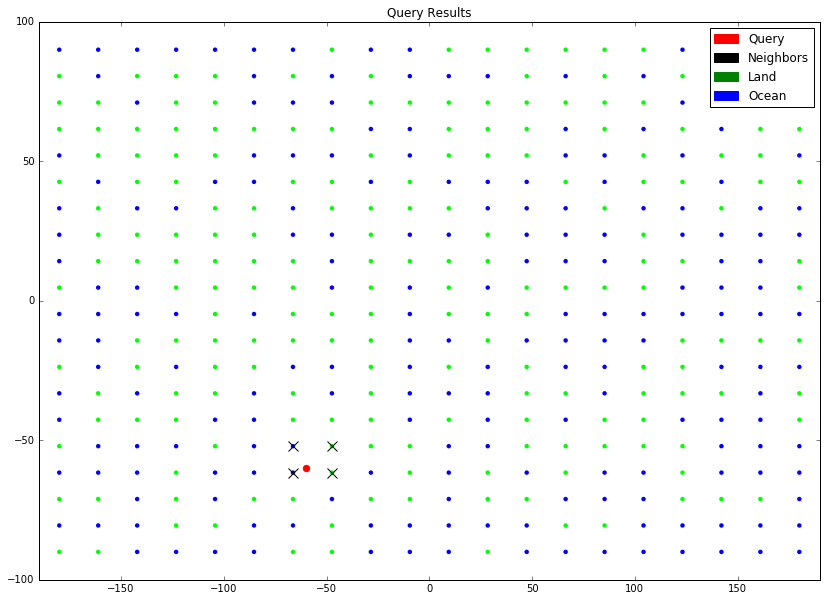

In [112]:
remove_test([-60,-60])

OCEAN NEIGHBOR(S): KEEP FLOAT AT QUERY POINT


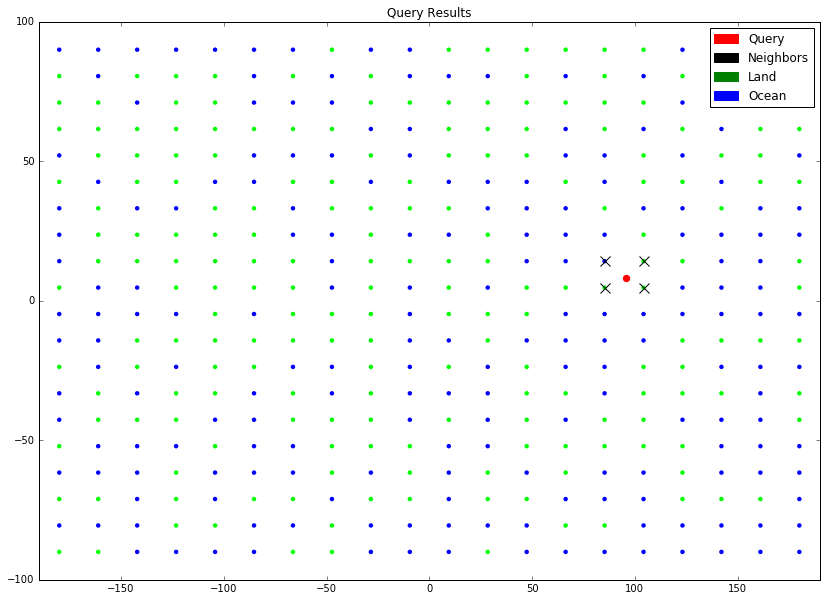

In [113]:
remove_test([95.5,8.20])